In [2]:
# Copyright 2019 Steven Mattis and Troy Butler

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde as GKDE
from luq import *

The model is the 1D Burger's equation, a nonlinear PDE used to model fluid dynamics:
$$q_t + \frac{1}{2} (q^2)_x = 0.$$
The domain is the interval $[0, 10]$.
We have an initial condition of the form
\begin{equation*}
q(x,0) = \begin{cases} 
      f_l & 0 \leq x\leq 3.25 -a  \\
       \frac{1}{2} ((f_l + f_r) - (f_l - f_r) \frac{(x-3.25)}{a}) & 3.25 -a < x \leq 3.25 + a \\
      f_r & 3.25 + a < x \leq 10,
   \end{cases}
\end{equation*}
where $a \in [0, 3]$ is an uncertain parameter and $f_l$ and $f_r$ are positive constants with $f_l > f_r$. 
Take $f_l = 1.5$ and $f_r = 1$.
We assume non-reflecting boundary conditions, allowing waves to pass out of the boundaries without reflection.

Text(0.5, 1.0, 'Initial Condition')

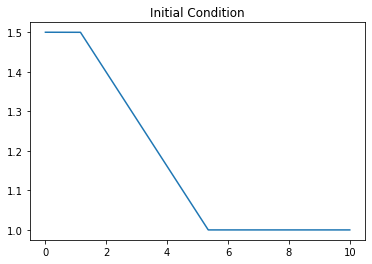

In [3]:
# Plot the initial condition given a, fl, and fr.
a = 2.1
fl = 1.5; fr = 1;
x = np.linspace(0, 10, 1000)
q0 = np.zeros(x.shape)
for i in range(x.shape[0]):
    if x[i] <= (3.25 - a):
        q0[i] = fl
    elif x[i] > (3.25 + a):
        q0[i] = fr
    else:
         q0[i] = 0.5 * ((fl + fr) - (fl - fr) * (x[i] - 3.25) / a)
fig = plt.figure()
plt.plot(x, q0)
plt.title('Initial Condition')

This system often can develop discontinuous solutions (shock waves), which complicates calculating a numerical solution. 
We use Clawpack (https://www.clawpack.org/) to calculate weak solutions to the system using a Godunov-type finite volume method with an appropriate limiter and Riemann solver. 
We use a uniform mesh with 500 elements.

The system described above forms a shock at $t = \frac{2a}{f_l - f_r}$.
The shock speed is $\frac{1}{2}(f_l + f_r)$.

We calculte the time series solution at $x=7$, i.e. $q(7,t)$ at 500 evenly spaced time steps between 0 and 10.

Two ***true*** distributions of $a$ are defined by (non-uniform)
Beta distributions and used to generate a set of time series data.

An ***initial*** uniform distribution is assumed and updated by the true time series data.

In [4]:
# Load precomputed time-series data.
times = np.loadtxt('burgers_files_v2/unif_times.txt')
predicted_time_series = np.loadtxt('burgers_files_v2/unif_series.txt')
params = np.loadtxt('burgers_files_v2/unif_params.txt')
num_samples = predicted_time_series.shape[0]

# a=5, b=2
observed_time_series = np.loadtxt('burgers_files_v2/beta_series_5_2.txt')
params_obs = np.loadtxt('burgers_files_v2/beta_params_5_2.txt')
num_obs = observed_time_series.shape[0]

if len(params.shape) == 1:
    params = params.reshape((num_samples, 1))
    params_obs = params_obs.reshape((num_obs, 1))
param_range = np.array([[0.0, 3.0]])
param_labels = [r'$a$']

In [5]:
# Use LUQ to learn dynamics and QoIs
learn = LUQ(predicted_time_series, observed_time_series, times)

# time array indices over which to use
time_start_idx = 0 #0
time_end_idx = 250 #499

# Clean data with piecewise constant linear splines
learn.clean_data_tol(time_start_idx=time_start_idx, time_end_idx=time_end_idx,
                 num_clean_obs=200, tol=1.0e-3, min_knots=5, max_knots=15)


0 5 0.0004237123112325103
0 5 knots being used
1 5 0.00036649082513512236
1 5 knots being used
2 5 0.0005827198887121139
2 5 knots being used
3 5 0.0010187963131906366
3 6 0.0010187963151676845
3 7 0.0004587159644781439
3 7 knots being used
4 5 0.0016303021205407223
4 6 0.000721924574237651
4 6 knots being used
5 5 0.0012896650314861847
5 6 0.0005693099094179379
5 6 knots being used
6 5 0.0011661514780246598
6 6 0.0005167531276318957
6 6 knots being used
7 5 0.0008629128497420456
7 5 knots being used
8 5 0.00028710719405496317
8 5 knots being used
9 5 0.001261624480360702
9 6 0.0005707760915466511
9 6 knots being used
10 5 0.0013156846774282519
10 6 0.0005840989349092982
10 6 knots being used
11 5 0.0008718796462492547
11 5 knots being used
12 5 0.0017597757350177635
12 6 0.0007813648447901626
12 6 knots being used
13 5 0.0013999567838279127
13 6 0.0006197930242174906
13 6 knots being used
14 5 0.001296572262841547
14 6 0.0005720969820052087
14 6 knots being used
15 5 0.001873148333216

/Users/smattis/src/anaconda3/anaconda3/envs/loq.py/lib/python3.6/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


107 5 0.00436491779245955
107 6 0.0008814104140761772
107 6 knots being used
108 5 0.001442310002809672
108 6 0.0006393349414537174
108 6 knots being used
109 5 0.0015198419408238774
109 6 0.0006848306216761961
109 6 knots being used
110 5 0.0010052133450241562
110 6 0.0004592273872200136
110 6 knots being used
111 5 0.0015054132863722993
111 6 0.0006661888454990771
111 6 knots being used
112 5 0.0004237174255537405
112 5 knots being used
113 5 0.0006744501085243311
113 5 knots being used
114 5 0.00042371508874278484
114 5 knots being used
115 5 0.001614892306856466
115 6 0.0007157040038452187
115 6 knots being used
116 5 0.0007047102204894005
116 5 knots being used
117 5 0.0010356138747619835
117 6 0.00047113447372273205
117 6 knots being used
118 5 0.0014805093417072496
118 6 0.0006635054568262913
118 6 knots being used
119 5 0.0003990501124484784
119 5 knots being used
120 5 0.0008317616784003325
120 5 knots being used
121 5 0.0010097630526839634
121 6 0.0004551953784680067
121 6 kn

240 5 0.0012036985793155799
240 6 0.0005427491929334265
240 6 knots being used
241 5 0.001188604066004215
241 6 0.0005349652520362795
241 6 knots being used
242 5 0.0003561793665619129
242 5 knots being used
243 5 0.0002501475445471137
243 5 knots being used
244 5 0.000842296695070121
244 5 knots being used
245 5 0.0014819369965066852
245 6 0.0006541181476566429
245 6 knots being used
246 5 0.0011887470407475136
246 6 0.0005248261772410058
246 6 knots being used
247 5 0.000443820554308147
247 5 knots being used
248 5 0.0014961356859810677
248 6 0.0006734646504274668
248 6 knots being used
249 5 0.00029958654061399434
249 5 knots being used
250 5 0.0016042315947344236
250 6 0.0007121167644035743
250 6 knots being used
251 5 2.874838129917417e-05
251 5 knots being used
252 5 0.0007804303784084971
252 5 knots being used
253 5 0.0016906466268723477
253 6 0.0007476439148344155
253 6 knots being used
254 5 0.00044382270272491463
254 5 knots being used
255 5 0.0011342653572435533
255 6 0.0005

374 6 0.0006078213602567509
374 6 knots being used
375 5 0.0004687545093183636
375 5 knots being used
376 5 0.0018844586857349286
376 6 0.0008260581835335944
376 6 knots being used
377 5 0.00044381922144734893
377 5 knots being used
378 5 0.0004217575752464365
378 5 knots being used
379 5 8.294387449861776e-06
379 5 knots being used
380 5 0.00042371689342608174
380 5 knots being used
381 5 0.0008225509275092178
381 5 knots being used
382 5 0.0005137011537783957
382 5 knots being used
383 5 0.0004918177958577232
383 5 knots being used
384 5 0.001600690099025328
384 6 0.0007105700212241144
384 6 knots being used
385 5 0.001444012584529904
385 6 0.0006504207535493914
385 6 knots being used
386 5 0.0003178910975918289
386 5 knots being used
387 5 0.00044381922200095503
387 5 knots being used
388 5 0.00032932876596083847
388 5 knots being used
389 5 0.0004438189494886935
389 5 knots being used
390 5 0.00023567497538334628
390 5 knots being used
391 5 0.0018361058541790393
391 6 0.0008158088

9 6 0.000813040616600927
9 6 knots being used.
10 5 0.0013102134160586716
10 6 0.0005776417840140335
10 6 knots being used.
11 5 0.0014791135915838696
11 6 0.0006623913760533005
11 6 knots being used.
12 5 0.0016297766183925137
12 6 0.0007226978934378941
12 6 knots being used.
13 5 0.0016610385802070578
13 6 0.0007360663161858771
13 6 knots being used.
14 5 0.0018768879901283396
14 6 0.0008237887837809104
14 6 knots being used.
15 5 0.0008317502458314705
15 5 knots being used.
16 5 0.0009370217901834096
16 5 knots being used.
17 5 0.0012048365925226756
17 6 0.0005435277575525702
17 6 knots being used.
18 5 0.0010366531810800273
18 6 0.00046310278443229436
18 6 knots being used.
19 5 0.0016253337542046459
19 6 0.0007189204797195996
19 6 knots being used.
20 5 0.0016711977184152846
20 6 0.000738684226142588
20 6 knots being used.
21 5 0.0006861854496714905
21 5 knots being used.
22 5 0.0008812063005427673
22 5 knots being used.
23 5 0.0007232855058643295
23 5 knots being used.
24 5 0.001

125 5 0.0006455208004524438
125 5 knots being used.
126 5 0.001251402254821991
126 6 0.0005564940209550844
126 6 knots being used.
127 5 0.0018713240555603503
127 6 0.0008300300216246661
127 6 knots being used.
128 5 0.0016414119627938934
128 6 0.0007281647734419291
128 6 knots being used.
129 5 0.0014341332357979363
129 6 0.000636792796889179
129 6 knots being used.
130 5 0.0004624851645856069
130 5 knots being used.
131 5 0.000889724526110068
131 5 knots being used.
132 5 0.0013361196003096629
132 6 0.0005923856149150288
132 6 knots being used.
133 5 0.001508800854498506
133 6 0.0006686164687804577
133 6 knots being used.
134 5 0.0007612289758509048
134 5 knots being used.
135 5 0.0011197361941972235
135 6 0.0005047347313500208
135 6 knots being used.
136 5 0.0018261022902647224
136 6 0.0008020589778584038
136 6 knots being used.
137 5 0.0014702935610341422
137 6 0.0006487754542937364
137 6 knots being used.
138 5 0.000602512327528044
138 5 knots being used.
139 5 0.00121811052107732

239 5 0.0006478551784206623
239 5 knots being used.
240 5 0.0006817904262783736
240 5 knots being used.
241 5 0.0014623667741134434
241 6 0.0006483147121846672
241 6 knots being used.
242 5 0.0017992868500863028
242 6 0.0007983642845458286
242 6 knots being used.
243 5 0.0017030747025564134
243 6 0.0007570766740429156
243 6 knots being used.
244 5 0.0008809244524895199
244 5 knots being used.
245 5 0.001374860505820048
245 6 0.0006096938551304748
245 6 knots being used.
246 5 0.0014966585395030892
246 6 0.0006635639688916062
246 6 knots being used.
247 5 0.00103712039322225
247 6 0.0004721122236030886
247 6 knots being used.
248 5 0.0012926019284100214
248 6 0.0005841332150333643
248 6 knots being used.
249 5 0.0018197199194726434
249 6 0.0008057862192134726
249 6 knots being used.
250 5 0.0014259339971966615
250 6 0.0006389974436623344
250 6 knots being used.
251 5 0.0006228655665435275
251 5 knots being used.
252 5 0.0006615730393161027
252 5 knots being used.
253 5 0.000794581695914

353 5 0.0010760794206230017
353 6 0.00048729300649102595
353 6 knots being used.
354 5 0.0013108373625125326
354 6 0.0005777132605399008
354 6 knots being used.
355 5 0.0016211314921255745
355 6 0.0007175820524686436
355 6 knots being used.
356 5 0.0015376143273051525
356 6 0.0006816924755644392
356 6 knots being used.
357 5 0.001205321857033442
357 6 0.0005438599447941546
357 6 knots being used.
358 5 0.0012821620553513837
358 6 0.0005767013015760932
358 6 knots being used.
359 5 0.001828580857889027
359 6 0.0008116276912185149
359 6 knots being used.
360 5 0.0011456888640651928
360 6 0.0005087319932975427
360 6 knots being used.
361 5 0.0012235156753300468
361 6 0.0005416347036213824
361 6 knots being used.
362 5 0.0016866540708359832
362 6 0.0007488695306259709
362 6 knots being used.
363 5 0.0017244630847395852
363 6 0.0007629744320779414
363 6 knots being used.
364 5 0.0013968916870139851
364 6 0.0006185076070023677
364 6 knots being used.
365 5 0.0014453008919606913
365 6 0.00064

468 6 0.0005581658346453733
468 6 knots being used.
469 5 0.0012345615714509264
469 6 0.0005572492122421012
469 6 knots being used.
470 5 0.0017308795654953915
470 6 0.0007669443169351119
470 6 knots being used.
471 5 0.0015933743527128538
471 6 0.0007074311074584082
471 6 knots being used.
472 5 0.0018805094261593503
472 6 0.000824255082932281
472 6 knots being used.
473 5 0.0006944671542772718
473 5 knots being used.
474 5 0.0017709287782667216
474 6 0.0007781950859727045
474 6 knots being used.
475 5 0.0008963686708459221
475 5 knots being used.
476 5 0.0019559738901355882
476 6 0.0008619919544013284
476 6 knots being used.
477 5 0.0009216368090578985
477 5 knots being used.
478 5 0.0015492562578077102
478 6 0.0006838162071568803
478 6 knots being used.
479 5 0.0010794305383080914
479 6 0.0004760772783241372
479 6 knots being used.
480 5 0.0011208575215440127
480 6 0.000510070429346117
480 6 knots being used.
481 5 0.0011702829491356864
481 6 0.0005322879563193316
481 6 knots being 

(array([[0.9999995 , 0.99999952, 0.99999953, ..., 1.50087325, 1.50090962,
         1.50094599],
        [0.99990123, 0.99990406, 0.9999069 , ..., 1.50001343, 1.50001408,
         1.50001473],
        [0.9998107 , 0.99981664, 0.99982257, ..., 1.50001681, 1.50001771,
         1.50001861],
        ...,
        [0.99996877, 0.99996957, 0.99997036, ..., 1.50087325, 1.50090962,
         1.50094599],
        [0.99979009, 0.99979741, 0.99980472, ..., 1.50000453, 1.50000481,
         1.50000508],
        [0.99999958, 0.99999959, 0.9999996 , ..., 1.4999827 , 1.49998197,
         1.49998124]]),
 array([[0.99993513, 0.99993818, 0.99994122, ..., 1.50001831, 1.50001986,
         1.50002142],
        [0.99988789, 0.99989597, 0.99990405, ..., 1.50000503, 1.50000581,
         1.50000659],
        [0.99988276, 0.99988801, 0.99989326, ..., 1.50001406, 1.50001521,
         1.50001636],
        ...,
        [0.99989474, 0.99989786, 0.99990097, ..., 1.50000909, 1.50000954,
         1.50001   ],
        [0.9

In [6]:
# Learn and classify dynamics.
learn.dynamics(cluster_method='spectral', kwargs={'n_clusters': 3, 'n_init': 10})

0.006 misclassification rate for  {'kernel': 'linear'}
0.22400000000000003 misclassification rate for  {'kernel': 'rbf'}
0.024 misclassification rate for  {'kernel': 'poly'}
0.5840000000000001 misclassification rate for  {'kernel': 'sigmoid'}
Best classifier is  {'kernel': 'linear'}
Misclassification rate is  0.006


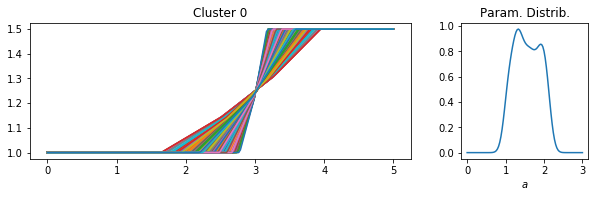

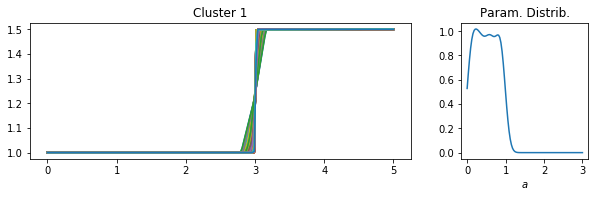

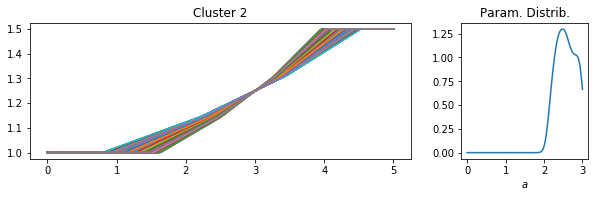

In [7]:
# Plot clusters of predicted time series
for j in range(learn.num_clusters):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,2.5), gridspec_kw={'width_ratios': [3, 1]}) #(figsize=(10,5))
    ps = []
    for i in range(num_samples):
        if learn.predict_labels[i] == j:
            ps.append(params[i,0])
            ax1.plot(learn.clean_times, learn.clean_predictions[i, :])
            #ax2.plot(times[time_start_idx : time_end_idx + 1], predicted_time_series[i, time_start_idx : time_end_idx + 1])
    ax1.set(title='Cluster ' + str(j))
    xs = np.linspace(param_range[0, 0], param_range[0,1], 100)
    ax2.plot(xs, GKDE(ps)(xs))
    ax2.set(xlabel=param_labels[0], title='Param. Distrib.')

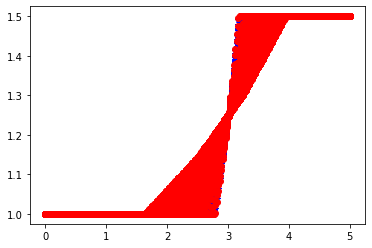

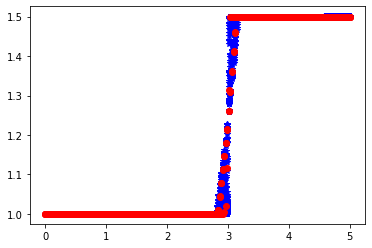

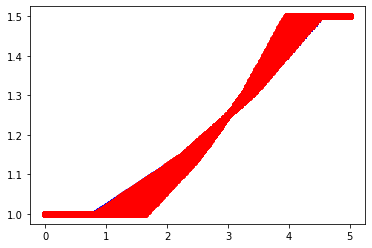

In [8]:
# Plot observed and predicted clusters
for j in range(learn.num_clusters):
    plt.figure()
    cluster_num = j
    for i in range(num_samples):
        if learn.predict_labels[i] == cluster_num:
            plt.plot(learn.clean_times, learn.clean_predictions[i,:],'b*')
    for i in range(num_obs):
        if learn.obs_labels[i] == cluster_num:
            plt.plot(learn.clean_times, learn.clean_obs[i,:],'ro')

In [9]:
# Find best KPCA transformation for given number of QoI and transform time series data.
predict_map, obs_map = learn.learn_qois_and_transform(num_qoi=1) #variance_rate=0.95) #num_qoi=1)

1 principal components explain 55.3272% of variance for cluster 0 with {'kernel': 'linear'}
1 principal components explain 24.1905% of variance for cluster 0 with {'kernel': 'rbf'}
1 principal components explain 64.2239% of variance for cluster 0 with {'kernel': 'sigmoid'}
1 principal components explain 32.6437% of variance for cluster 0 with {'kernel': 'poly'}
1 principal components explain 49.6074% of variance for cluster 0 with {'kernel': 'cosine'}
Best kPCA for cluster  0  is  {'kernel': 'sigmoid'}
1 principal components explain 64.2239% of variance.
1 principal components explain 61.1540% of variance for cluster 1 with {'kernel': 'linear'}
1 principal components explain 47.0377% of variance for cluster 1 with {'kernel': 'rbf'}
1 principal components explain 62.6215% of variance for cluster 1 with {'kernel': 'sigmoid'}
1 principal components explain 86.4305% of variance for cluster 1 with {'kernel': 'poly'}
1 principal components explain 53.4061% of variance for cluster 1 with {'ke

In [10]:
# Generate kernel density estimates on new QoI
learn.generate_kdes()
# Calculate rejection rates for each cluster and print averages.
r_vals=learn.compute_r()

Average rejection rates for clusters: [1.0041049535631148, 0.5717100726294155, 1.0288099438950606]


In [11]:
# Compute marginal probablities for each parameter and initial condition.
param_marginals = []
true_param_marginals = []
lam_ptr = []
cluster_weights = []
for i in range(learn.num_clusters):
    lam_ptr.append(np.where(learn.predict_labels == i)[0])
    cluster_weights.append(len(np.where(learn.obs_labels == i)[0]) / num_obs)

for i in range(params.shape[1]):
    true_param_marginals.append(GKDE(params_obs[:,i]))
    param_marginals.append([])
    for j in range(learn.num_clusters):
        param_marginals[i].append(GKDE(params[lam_ptr[j], i], weights=learn.r[j]))
        

In [12]:
# uniform distribution
def unif_dist(x, p_range):
    y = np.zeros(x.shape)
    val = 1.0/(p_range[1] - p_range[0])
    for i, xi in enumerate(x):
        if xi < p_range[0] or xi >  p_range[1]:
            y[i] = 0
        else:
            y[i] = val
    return y

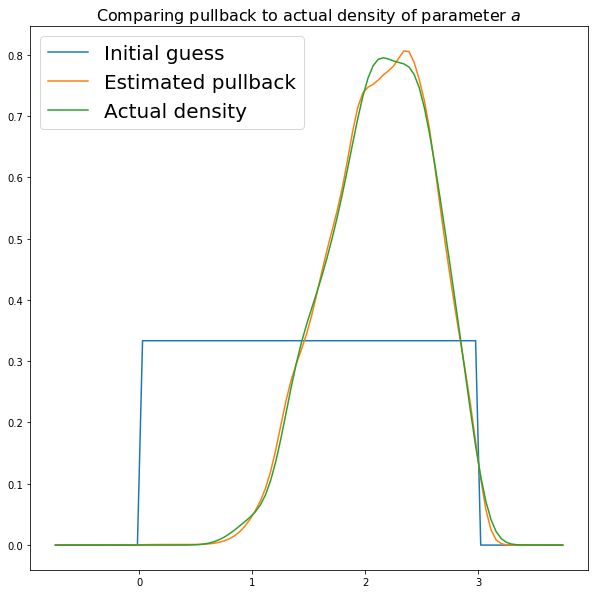

In [13]:
# Plot predicted marginal densities for parameters

for i in range(params.shape[1]):
    fig = plt.figure(figsize=(10,10))
    fig.clear()
    x_min = min(min(params[:, i]), min(params_obs[:, i]))
    x_max = max(max(params[:, i]), max(params_obs[:, i]))
    delt = 0.25*(x_max - x_min)
    x = np.linspace(x_min-delt, x_max+delt, 100)
    plt.plot(x, unif_dist(x, param_range[i, :]),
         label = 'Initial guess')
    mar = np.zeros(x.shape)
    for j in range(learn.num_clusters):
        mar += param_marginals[i][j](x) * cluster_weights[j]
    plt.plot(x, mar, label = 'Estimated pullback')
    plt.plot(x, true_param_marginals[i](x), label = 'Actual density')
    plt.title('Comparing pullback to actual density of parameter ' + param_labels[i], fontsize=16)
    plt.legend(fontsize=20)

In [14]:
# Load precomputed time-series data.
# a=2, b=5
observed_time_series2 = np.loadtxt('burgers_files_v2/beta_series_2_5.txt')
params_obs2 = np.loadtxt('burgers_files_v2/beta_params_2_5.txt')
num_obs2 = observed_time_series.shape[0]
params_obs2 = params_obs2.reshape((num_obs2, 1))


In [15]:
# Use LUQ to learn dynamics and QoIs
learn2 = LUQ(predicted_time_series, observed_time_series2, times)

# time array indices over which to use
time_start_idx = 0 #0
time_end_idx = 250 #499

# Clean data with piecewise constant linear splines
learn2.clean_data_tol(time_start_idx=time_start_idx, time_end_idx=time_end_idx,
                 num_clean_obs=200, tol=1.0e-3, min_knots=5, max_knots=15)


0 5 0.0004237123112325103
0 5 knots being used
1 5 0.00036649082513512236
1 5 knots being used
2 5 0.0005827198887121139
2 5 knots being used
3 5 0.0010187963131906366
3 6 0.0010187963151676845
3 7 0.0004587159644781439
3 7 knots being used
4 5 0.0016303021205407223
4 6 0.000721924574237651
4 6 knots being used
5 5 0.0012896650314861847
5 6 0.0005693099094179379
5 6 knots being used
6 5 0.0011661514780246598
6 6 0.0005167531276318957
6 6 knots being used
7 5 0.0008629128497420456
7 5 knots being used
8 5 0.00028710719405496317
8 5 knots being used
9 5 0.001261624480360702
9 6 0.0005707760915466511
9 6 knots being used
10 5 0.0013156846774282519
10 6 0.0005840989349092982
10 6 knots being used
11 5 0.0008718796462492547
11 5 knots being used
12 5 0.0017597757350177635
12 6 0.0007813648447901626
12 6 knots being used
13 5 0.0013999567838279127
13 6 0.0006197930242174906
13 6 knots being used
14 5 0.001296572262841547
14 6 0.0005720969820052087
14 6 knots being used
15 5 0.001873148333216

/Users/smattis/src/anaconda3/anaconda3/envs/loq.py/lib/python3.6/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


109 5 0.0015198419408238774
109 6 0.0006848306216761961
109 6 knots being used
110 5 0.0010052133450241562
110 6 0.0004592273872200136
110 6 knots being used
111 5 0.0015054132863722993
111 6 0.0006661888454990771
111 6 knots being used
112 5 0.0004237174255537405
112 5 knots being used
113 5 0.0006744501085243311
113 5 knots being used
114 5 0.00042371508874278484
114 5 knots being used
115 5 0.001614892306856466
115 6 0.0007157040038452187
115 6 knots being used
116 5 0.0007047102204894005
116 5 knots being used
117 5 0.0010356138747619835
117 6 0.00047113447372273205
117 6 knots being used
118 5 0.0014805093417072496
118 6 0.0006635054568262913
118 6 knots being used
119 5 0.0003990501124484784
119 5 knots being used
120 5 0.0008317616784003325
120 5 knots being used
121 5 0.0010097630526839634
121 6 0.0004551953784680067
121 6 knots being used
122 5 0.0010198284393824783
122 6 0.00046854482596131523
122 6 knots being used
123 5 0.0004438229123183972
123 5 knots being used
124 5 0.0

247 5 0.000443820554308147
247 5 knots being used
248 5 0.0014961356859810677
248 6 0.0006734646504274668
248 6 knots being used
249 5 0.00029958654061399434
249 5 knots being used
250 5 0.0016042315947344236
250 6 0.0007121167644035743
250 6 knots being used
251 5 2.874838129917417e-05
251 5 knots being used
252 5 0.0007804303784084971
252 5 knots being used
253 5 0.0016906466268723477
253 6 0.0007476439148344155
253 6 knots being used
254 5 0.00044382270272491463
254 5 knots being used
255 5 0.0011342653572435533
255 6 0.0005135485763733679
255 6 knots being used
256 5 0.001994819027908501
256 6 0.0008788470693681681
256 6 knots being used
257 5 0.0010890220928279214
257 6 0.0004967407499152248
257 6 knots being used
258 5 0.0011388575970250267
258 6 0.0005128792134116488
258 6 knots being used
259 5 0.00017261971171947323
259 5 knots being used
260 5 0.00040694680799096124
260 5 knots being used
261 5 0.0004538255586830387
261 5 knots being used
262 5 0.0006161386852068884
262 5 kno

384 6 0.0007105700212241144
384 6 knots being used
385 5 0.001444012584529904
385 6 0.0006504207535493914
385 6 knots being used
386 5 0.0003178910975918289
386 5 knots being used
387 5 0.00044381922200095503
387 5 knots being used
388 5 0.00032932876596083847
388 5 knots being used
389 5 0.0004438189494886935
389 5 knots being used
390 5 0.00023567497538334628
390 5 knots being used
391 5 0.0018361058541790393
391 6 0.0008158088998946652
391 6 knots being used
392 5 0.002003346275413802
392 6 0.0008911422828151305
392 6 knots being used
393 5 0.0015798855376110018
393 6 0.000699636783138048
393 6 knots being used
394 5 0.0019242162435374388
394 6 0.0008460435417155682
394 6 knots being used
395 5 0.0017589268743714982
395 6 0.0007804185341024234
395 6 knots being used
396 5 0.00044382111606264626
396 5 knots being used
397 5 0.0014292018446185673
397 6 0.0006400575476867796
397 6 knots being used
398 5 0.0015021696402902106
398 6 0.0006658342902516835
398 6 knots being used
399 5 0.00

25 5 0.0010331250219930528
25 6 0.0004713162003509024
25 6 knots being used.
26 5 2.8748385289899025e-05
26 5 knots being used.
27 5 0.00017155808398896277
27 5 knots being used.
28 5 0.0004600385576940236
28 5 knots being used.
29 5 8.32346695378719e-06
29 5 knots being used.
30 5 8.641953387543814e-06
30 5 knots being used.
31 5 0.0005382291785439296
31 5 knots being used.
32 5 8.641985733812359e-06
32 5 knots being used.
33 5 0.0003636584011345667
33 5 knots being used.
34 5 8.641966043491611e-06
34 5 knots being used.
35 5 0.000782319377059746
35 5 knots being used.
36 5 0.00042371940449426287
36 5 knots being used.
37 5 2.8748380673656778e-05
37 5 knots being used.
38 5 0.0002801989526688462
38 5 knots being used.
39 5 8.641982528842288e-06
39 5 knots being used.
40 5 0.00042371302141073623
40 5 knots being used.
41 5 0.00030190111494465317
41 5 knots being used.
42 5 8.741068690332537e-06
42 5 knots being used.
43 5 0.0004411753173823204
43 5 knots being used.
44 5 8.641197006997

186 5 0.00035626045047356845
186 5 knots being used.
187 5 8.641955162611332e-06
187 5 knots being used.
188 5 0.0008674159360582281
188 5 knots being used.
189 5 0.00044383363104790667
189 5 knots being used.
190 5 8.641968569370238e-06
190 5 knots being used.
191 5 0.00039967116804616107
191 5 knots being used.
192 5 0.0019825611679473183
192 6 0.00040696285810280737
192 6 knots being used.
193 5 8.641967948979682e-06
193 5 knots being used.
194 5 0.0004325759055044926
194 5 knots being used.
195 5 0.00032544344173499973
195 5 knots being used.
196 5 0.00045222836594378953
196 5 knots being used.
197 5 0.00033004020461269515
197 5 knots being used.
198 5 0.00042371249463334744
198 5 knots being used.
199 5 0.0004373985595561955
199 5 knots being used.
200 5 0.00030161656007522187
200 5 knots being used.
201 5 0.00035639632514670663
201 5 knots being used.
202 5 2.8748453672875156e-05
202 5 knots being used.
203 5 8.641949622674084e-06
203 5 knots being used.
204 5 0.00044419128758892

347 5 8.641980733113577e-06
347 5 knots being used.
348 5 2.6834659127130023e-05
348 5 knots being used.
349 5 0.00031544777946692336
349 5 knots being used.
350 5 8.641873816318222e-06
350 5 knots being used.
351 5 0.0006185828976514999
351 5 knots being used.
352 5 2.8751406828961357e-05
352 5 knots being used.
353 5 0.00044382014512605054
353 5 knots being used.
354 5 0.0005461240917720687
354 5 knots being used.
355 5 0.0005522623905622414
355 5 knots being used.
356 5 8.64194454391933e-06
356 5 knots being used.
357 5 0.0003754657608088357
357 5 knots being used.
358 5 8.641964813133443e-06
358 5 knots being used.
359 5 8.641970964884462e-06
359 5 knots being used.
360 5 0.0003544744128485505
360 5 knots being used.
361 5 8.641959865981434e-06
361 5 knots being used.
362 5 0.0004438225828405298
362 5 knots being used.
363 5 8.641929420080044e-06
363 5 knots being used.
364 5 0.000329762936012379
364 5 knots being used.
365 5 0.00043150444791059206
365 5 knots being used.
366 5 0.0

(array([[0.9999995 , 0.99999952, 0.99999953, ..., 1.50087325, 1.50090962,
         1.50094599],
        [0.99990123, 0.99990406, 0.9999069 , ..., 1.50001343, 1.50001408,
         1.50001473],
        [0.9998107 , 0.99981664, 0.99982257, ..., 1.50001681, 1.50001771,
         1.50001861],
        ...,
        [0.99996877, 0.99996957, 0.99997036, ..., 1.50087325, 1.50090962,
         1.50094599],
        [0.99979009, 0.99979741, 0.99980472, ..., 1.50000453, 1.50000481,
         1.50000508],
        [0.99999958, 0.99999959, 0.9999996 , ..., 1.4999827 , 1.49998197,
         1.49998124]]),
 array([[0.9999995 , 0.99999952, 0.99999953, ..., 1.49998187, 1.49998111,
         1.49998034],
        [0.99983456, 0.9998395 , 0.99984444, ..., 1.50001077, 1.50001132,
         1.50001186],
        [0.9999995 , 0.99999952, 0.99999953, ..., 1.50087325, 1.50090962,
         1.50094599],
        ...,
        [0.9998776 , 0.99988106, 0.99988452, ..., 1.50000883, 1.50000925,
         1.50000967],
        [0.9

In [16]:
# Learn and classify dynamics.
learn2.dynamics(cluster_method='spectral', kwargs={'n_clusters': 3, 'n_init': 10})

0.008 misclassification rate for  {'kernel': 'linear'}
0.21600000000000003 misclassification rate for  {'kernel': 'rbf'}
0.026000000000000002 misclassification rate for  {'kernel': 'poly'}
0.584 misclassification rate for  {'kernel': 'sigmoid'}
Best classifier is  {'kernel': 'linear'}
Misclassification rate is  0.008


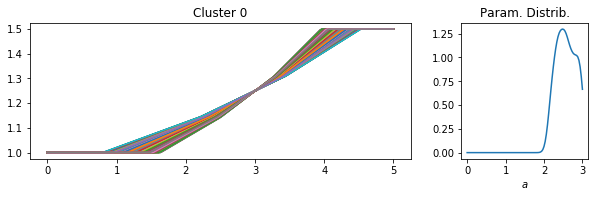

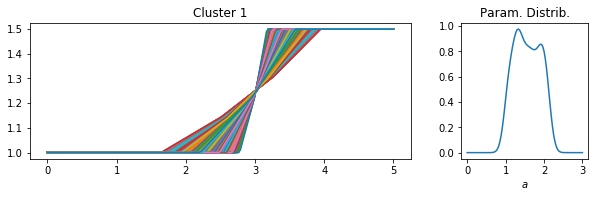

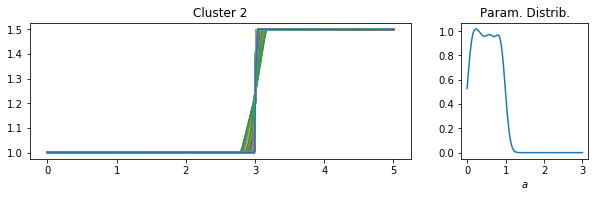

In [17]:
# Plot clusters of predicted time series
for j in range(learn.num_clusters):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,2.5), gridspec_kw={'width_ratios': [3, 1]}) #(figsize=(10,5))
    ps = []
    for i in range(num_samples):
        if learn2.predict_labels[i] == j:
            ps.append(params[i,0])
            ax1.plot(learn2.clean_times, learn2.clean_predictions[i, :])
            #ax2.plot(times[time_start_idx : time_end_idx + 1], predicted_time_series[i, time_start_idx : time_end_idx + 1])
    ax1.set(title='Cluster ' + str(j))
    xs = np.linspace(param_range[0, 0], param_range[0,1], 100)
    ax2.plot(xs, GKDE(ps)(xs))
    ax2.set(xlabel=param_labels[0], title='Param. Distrib.')

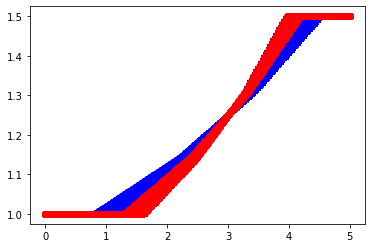

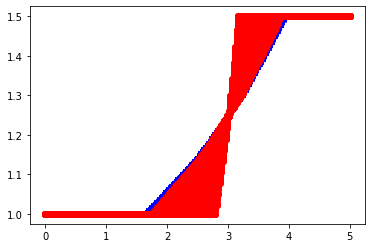

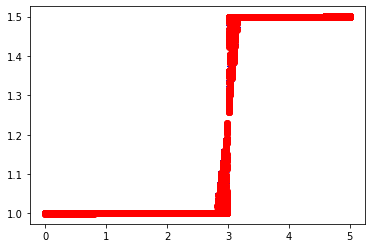

In [18]:
# Plot observed and predicted clusters
for j in range(learn2.num_clusters):
    plt.figure()
    cluster_num = j
    for i in range(num_samples):
        if learn2.predict_labels[i] == cluster_num:
            plt.plot(learn2.clean_times, learn2.clean_predictions[i,:],'b*')
    for i in range(num_obs2):
        if learn2.obs_labels[i] == cluster_num:
            plt.plot(learn2.clean_times, learn2.clean_obs[i,:],'ro')

In [19]:
# Find best KPCA transformation for given number of QoI and transform time series data.
predict_map2, obs_map2 = learn2.learn_qois_and_transform(num_qoi=3) #variance_rate=0.95) #num_qoi=1)

3 principal components explain 92.8150% of variance for cluster 0 with {'kernel': 'linear'}
3 principal components explain 65.9785% of variance for cluster 0 with {'kernel': 'rbf'}
3 principal components explain 95.4959% of variance for cluster 0 with {'kernel': 'sigmoid'}
3 principal components explain 82.5211% of variance for cluster 0 with {'kernel': 'poly'}
3 principal components explain 88.7628% of variance for cluster 0 with {'kernel': 'cosine'}
Best kPCA for cluster  0  is  {'kernel': 'sigmoid'}
3 principal components explain 95.4959% of variance.
3 principal components explain 87.4265% of variance for cluster 1 with {'kernel': 'linear'}
3 principal components explain 53.6014% of variance for cluster 1 with {'kernel': 'rbf'}
3 principal components explain 96.2808% of variance for cluster 1 with {'kernel': 'sigmoid'}
3 principal components explain 68.6064% of variance for cluster 1 with {'kernel': 'poly'}
3 principal components explain 88.5964% of variance for cluster 1 with {'ke

In [20]:
# Generate kernel density estimates on new QoI
learn2.generate_kdes()
# Calculate rejection rates for each cluster and print averages.
r_vals2=learn2.compute_r()

Average rejection rates for clusters: [0.7478736791834291, 0.8750877677311791, 1.0447873868571844]


In [21]:
# Compute marginal probablities for each parameter and initial condition.
param_marginals = []
true_param_marginals = []
lam_ptr = []
cluster_weights = []
for i in range(learn2.num_clusters):
    lam_ptr.append(np.where(learn2.predict_labels == i)[0])
    cluster_weights.append(len(np.where(learn2.obs_labels == i)[0]) / num_obs)

for i in range(params.shape[1]):
    true_param_marginals.append(GKDE(params_obs2[:,i]))
    param_marginals.append([])
    for j in range(learn2.num_clusters):
        param_marginals[i].append(GKDE(params[lam_ptr[j], i], weights=learn2.r[j]))

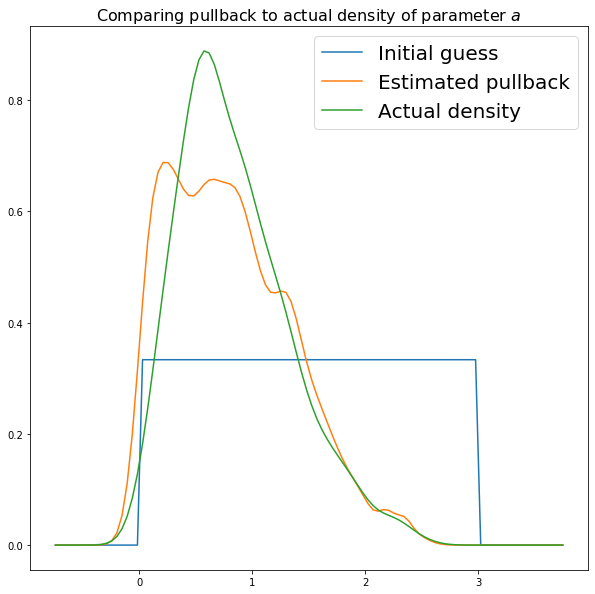

In [22]:
# Plot predicted marginal densities for parameters

for i in range(params.shape[1]):
    fig = plt.figure(figsize=(10,10))
    fig.clear()
    x_min = min(min(params[:, i]), min(params_obs[:, i]))
    x_max = max(max(params[:, i]), max(params_obs[:, i]))
    delt = 0.25*(x_max - x_min)
    x = np.linspace(x_min-delt, x_max+delt, 100)
    plt.plot(x, unif_dist(x, param_range[i, :]),
         label = 'Initial guess')
    mar = np.zeros(x.shape)
    for j in range(learn.num_clusters):
        mar += param_marginals[i][j](x) * cluster_weights[j]
    plt.plot(x, mar, label = 'Estimated pullback')
    plt.plot(x, true_param_marginals[i](x), label = 'Actual density')
    plt.title('Comparing pullback to actual density of parameter ' + param_labels[i], fontsize=16)
    plt.legend(fontsize=20)